In [4]:
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
import seaborn as sns
sns.set()

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("torch version:", torch.__version__)
print("device:", device)

torch version: 2.1.0+cu121
device: cuda


In [7]:
destination_directory = '/content/gdrive/MyDrive/Physionet_NPY_DATA/'

In [8]:
X_train_file_path = destination_directory + 'X_train.npy'
X_test_file_path = destination_directory + 'X_test.npy'
y_train_file_path = destination_directory + 'y_train.npy'
y_test_file_path = destination_directory + 'y_test.npy'

In [9]:
X_train_file_path

'/content/gdrive/MyDrive/Physionet_NPY_DATA/X_train.npy'

In [10]:
X_train = np.load(X_train_file_path, allow_pickle=True)
X_test = np.load(X_test_file_path, allow_pickle=True)
y_train = np.load(y_train_file_path, allow_pickle=True)
y_test = np.load(y_test_file_path, allow_pickle=True)

In [11]:
y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)

In [12]:
X_train = X_train[:10000,:,:]

In [13]:
X_train.shape

(10000, 5000, 12)

In [14]:
y_train = y_train[:10000]

In [15]:
y_list = y_train.tolist()

temp = None
faulty_set = list()
count = 0
for items in y_train:

    if len(items[0]) == 0:
       count += 1
       temp = items
       faulty_set.append(temp)
       continue

X_train = X_train[np.where(y_train != temp)[0]]
y_train = y_train[np.where(y_train != temp)[0]]
X_test = X_test[np.where(y_test != temp)[0]]
y_test = y_test[np.where(y_test != temp)[0]]

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9854, 5000, 12), (1901, 5000, 12), (9854, 1), (1901, 1))

In [14]:
# shape of one ECG
np.array(X_train[0]).shape

(5000, 12)

In [15]:

unique_values = np.unique(np.concatenate(y_train.flatten()))
print(f'All Labels: {unique_values}')

All Labels: ['CD' 'HYP' 'MI' 'NORM' 'STTC']


In [16]:
y_train.shape

(9854, 1)

In [17]:
x_out = list()
y_out = list()
to_pop = list()
sample_size = 5
count = 0
samples = 0
for i in y_train:
    if i[0] == ['CD'] and samples < sample_size:
        x_out.append(X_train[count])
        y_out.append(y_train[count])
        to_pop.append(count)
        X_train = np.delete(X_train, count, axis=0)
        y_train = np.delete(y_train, count, axis=0)
        samples += 1

    count += 1

In [18]:
np.array(x_out).shape, np.array(y_out).shape

((5, 5000, 12), (5, 1))

In [19]:
x_out

[array([[-0.009,  0.144,  0.153, ..., -0.051, -0.099, -0.066],
        [-0.012,  0.192,  0.204, ..., -0.068, -0.132, -0.088],
        [-0.015,  0.24 ,  0.255, ..., -0.085, -0.165, -0.11 ],
        ...,
        [-0.005,  0.01 ,  0.015, ..., -0.03 ,  0.03 ,  0.02 ],
        [-0.004,  0.008,  0.012, ..., -0.024,  0.024,  0.016],
        [-0.003,  0.006,  0.009, ..., -0.018,  0.018,  0.012]]),
 array([[-0.027, -0.021,  0.006, ..., -0.039, -0.015, -0.015],
        [-0.036, -0.028,  0.008, ..., -0.052, -0.02 , -0.02 ],
        [-0.045, -0.035,  0.01 , ..., -0.065, -0.025, -0.025],
        ...,
        [-0.045, -0.1  , -0.055, ..., -0.075, -0.08 , -0.065],
        [-0.036, -0.08 , -0.044, ..., -0.06 , -0.064, -0.052],
        [-0.027, -0.06 , -0.033, ..., -0.045, -0.048, -0.039]]),
 array([[-0.039, -0.048, -0.009, ..., -0.033,  0.021, -0.012],
        [-0.052, -0.064, -0.012, ..., -0.044,  0.028, -0.016],
        [-0.065, -0.08 , -0.015, ..., -0.055,  0.035, -0.02 ],
        ...,
        [-0.

In [20]:
y_out

[array([list(['CD'])], dtype=object),
 array([list(['NORM'])], dtype=object),
 array([list(['NORM'])], dtype=object),
 array([list(['CD'])], dtype=object),
 array([list(['HYP', 'MI'])], dtype=object)]

In [21]:
import gc
gc.collect()

0

In [22]:
y_out

[array([list(['CD'])], dtype=object),
 array([list(['NORM'])], dtype=object),
 array([list(['NORM'])], dtype=object),
 array([list(['CD'])], dtype=object),
 array([list(['HYP', 'MI'])], dtype=object)]

In [23]:
count

9854

In [24]:
X_train.shape

(9849, 5000, 12)

In [18]:
import pickle
with open('x_patient.pkl', 'wb') as file:
    pickle.dump(np.array(x_out), file)

with open('y_patient.pkl', 'wb') as file:
    pickle.dump(np.array(y_out), file)

# with open('new_X_train.pkl', 'wb') as file:
#     pickle.dump(np.array(X_train), file)

# with open('new_y_train.pkl', 'wb') as file:
#     pickle.dump(np.array(y_train), file)

In [26]:
np.array(x_out).shape, np.array(y_out).shape

((5, 5000, 12), (5, 1))

In [19]:
# category mapping to a number
num2class = np.array(['NORM', 'MI', 'STTC', 'CD', 'HYP'])

def label2num(labels):
    for index in range(len(labels)):
        labels[index] = np.where(num2class == labels[index][0][0])[0]

In [28]:
# y_train_copy = y_train.copy()
# y_test_copy = y_test.copy()

In [29]:
# label2num(y_train_copy)
# label2num(y_test_copy)

In [20]:
label2num(y_train)
label2num(y_test)

In [21]:
y_train = y_train.flatten().astype(np.int32)
y_test = y_test.flatten().astype(np.int32)

In [32]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9849, 5000, 12), (1901, 5000, 12), (9849,), (1901,))

In [22]:
batch_size = 16

In [34]:
X_train.shape

(9849, 5000, 12)

In [23]:
X_train = X_train.reshape(X_train.shape[0], 1, 5000, 12)
X_test = X_test.reshape(X_test.shape[0], 1, 5000, 12)

In [24]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


In [25]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [26]:

class BasicBlock(nn.Module):

    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels),
            )

    def forward(self, x):
        out = self.features(x)
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

In [27]:

basic_block = BasicBlock(64, 128)
print(basic_block)
x = torch.randn(2, 64, 500, 12)
y = basic_block(x)
print(y.shape)

BasicBlock(
  (features): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (shortcut): Sequential(
    (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
torch.Size([2, 128, 500, 12])


In [28]:
class Bottleneck(nn.Module):

    expansion = 4

    def __init__(self, in_channels, zip_channels, stride=1):
        super(Bottleneck, self).__init__()
        out_channels = self.expansion * zip_channels
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, zip_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(zip_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(zip_channels, zip_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(zip_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(zip_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.features(x)
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

In [29]:
bottleneck = Bottleneck(256, 128)
print(bottleneck)
x = torch.randn(2, 256, 32, 32)
y = bottleneck(x)
print(y.shape)

Bottleneck(
  (features): Sequential(
    (0): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (shortcut): Sequential(
    (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
torch.Size([2, 512, 32, 32])


In [30]:
class ResNet(nn.Module):
    """
    ResNet architecture for processing input images. This class initializes the network with
    convolutional layers, followed by multiple residual blocks, average pooling, and a final
    fully connected layer for classification.

    The network architecture is designed to process input images and output class scores for
    a specified number of classes. It utilizes the concept of residual learning with either
    BasicBlock or Bottleneck blocks to enable deep network architectures.
    """

    def __init__(self, block, num_blocks, num_classes=5):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(7, 1), stride=(2, 1), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        # Initialize residual blocks
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # Use adaptive average pooling to ensure the output size is (batch_size, channels, 1, 1)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # The classifier linear layer; adjust in_features based on the block expansion and the output of avg_pool
        self.classifier = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        # Pass input through the initial features
        out = self.features(x)

        # Pass through each residual layer
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        # Apply adaptive average pooling and flatten the output
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)  # Flatten the output for the fully connected layer

        # Pass through the classifier to get class scores
        out = self.classifier(out)
        return out

In [31]:
def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

In [32]:
net = ResNet34().to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    torch.backends.cudnn.benchmark = True

Train Model

In [33]:
lr = 1e-1
momentum = 0.9
weight_decay = 5e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold=0.1, patience=3, verbose=True)

In [34]:
# training function
def train(epoch):
    print('\nEpoch: %d' % (epoch))
    net.train()
    train_loss = torch.Tensor([0.0]).float().to(device)
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets.long())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        if batch_idx % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.6f |  Acc: %.3f%% (%d/%d)' %
              (epoch + 1, batch_idx + 1, train_loss.item(), 100.*correct/total, correct, total))
    return train_loss, (100.*correct/total)

In [ ]:
load_model = False
if load_model:
    checkpoint = torch.load('./checkpoint/res18.ckpt')
    net.load_state_dict(checkpoint['net'])
    start_epoch = checkpoint['epoch']
else:
    start_epoch = 0
print('start_epoch: %s' % start_epoch)

In [ ]:
train_metrics = {
    'epoch': list(),
    'loss': list(),
    'accuracy': list()
}
test_metrics = {
    'epoch': list(),
    'loss': list(),
    'accuracy': list()
}
train_loss_list = list()
accuracy_list = list()
total_epochs = 5
for epoch in range(start_epoch, total_epochs):
    loss, accuracy = train(epoch)
    train_metrics['epoch'].append(epoch)
    train_metrics['loss'].append(loss)
    train_metrics['accuracy'].append(accuracy)
    print('Total loss: %.6f' % loss)
    start_epoch = epoch
    scheduler.step(loss)

    # Validation loop
    net.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = net(inputs.to(device))
            loss = criterion(outputs, labels.long().to(device))
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
    test_metrics['loss'].append(loss)
    test_metrics['accuracy'].append(100.*correct/total)
    test_metrics['epoch'].append(epoch)
    print(f'Epoch {epoch + 1}/{total_epochs}, Loss: {loss.item():.4f}, Validation Accuracy: {100 * correct / total:.2f}%')

In [ ]:
torch.save(net.state_dict(), 'resnet.pth')

In [50]:
shutil.copy('resnet.pth', '/content/gdrive/MyDrive/Physionet_NPY_DATA')

'/content/gdrive/MyDrive/Physionet_NPY_DATA/resnet.pth'

In [51]:
test_metrics['loss'] = [_.cpu() for _ in test_metrics['loss']]

In [52]:

train_metrics['loss'] = [_.cpu() for _ in train_metrics['loss']]

In [53]:
test_metrics['loss']

[tensor(1.9355),
 tensor(1.1979),
 tensor(1.1739),
 tensor(1.0026),
 tensor(1.0256)]

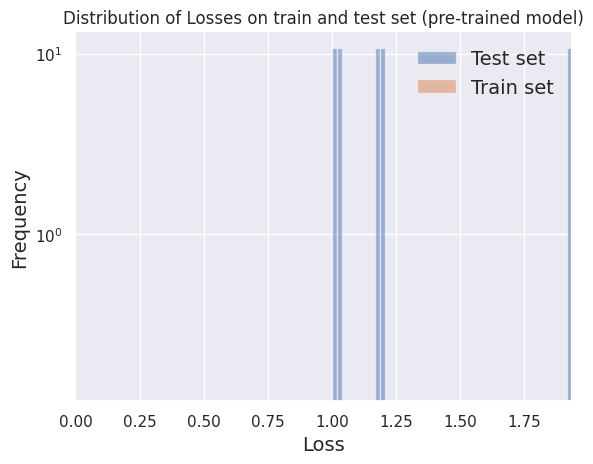

In [54]:
plt.title("Distribution of Losses on train and test set (pre-trained model)")
plt.hist(test_metrics['loss'], density=True, alpha=0.5, bins=50, label="Test set")
plt.hist(train_metrics['loss'], density=True, alpha=0.5, bins=50, label="Train set")
plt.xlabel("Loss", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xlim((0, np.max(test_metrics['loss'])))
plt.yscale("log")
plt.legend(frameon=False, fontsize=14)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

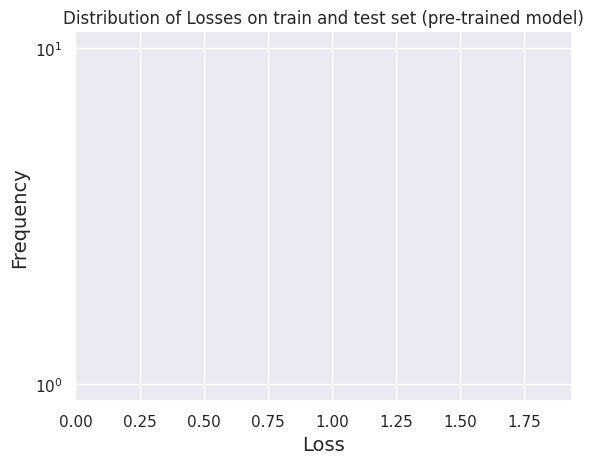

In [55]:
plt.title("Distribution of Losses on train and test set (pre-trained model)")
plt.xlabel("Loss", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xlim((0, np.max(test_metrics['loss'])))
plt.yscale("log")
plt.legend(frameon=False, fontsize=14)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

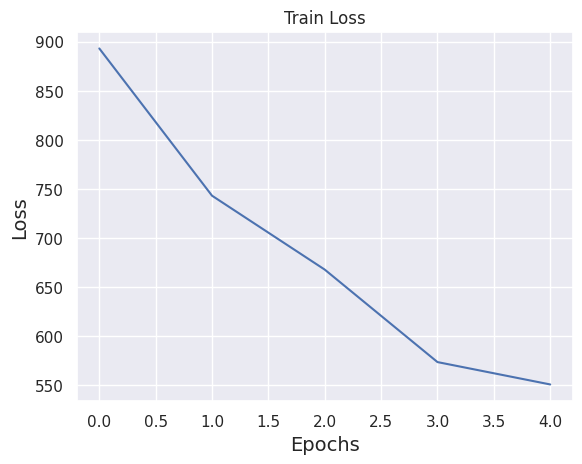

In [56]:
plt.title("Train Loss")
plt.plot(train_metrics['loss'])
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.show()

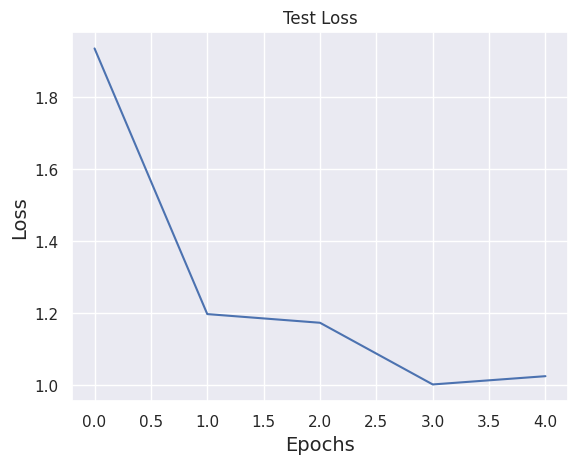

In [57]:
plt.title("Test Loss")
plt.plot(test_metrics['loss'])
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.show()

In [58]:
def compute_losses(net, loader):
    """Auxiliary function to compute per-sample losses"""

    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        logits = net(inputs)
        losses = criterion(logits, targets.long()).numpy(force=True)
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)


train_losses = compute_losses(net, train_loader)

In [93]:
torch.cuda.empty_cache()
from tqdm import tqdm

In [95]:
# del net

In [35]:
net = ResNet34().to(device)
# chk = torch.load('resnet.pth')
# model.load_state_dict(chk['model_state_dict'])
state_dict = torch.load('/content/gdrive/MyDrive/Physionet_NPY_DATA/resnet.pth')

# Apply the weights
net.load_state_dict(state_dict)

<All keys matched successfully>

In [36]:
net.eval()

ResNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 1), stride=(2, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (features): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (features): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [37]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
all_losses = list()

with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)
        # print(inputs.shape, targets.shape, outputs.shape)
        loss = criterion(outputs, targets.long())
        all_losses.append(loss)

        # for inputs, labels in test_loader:
        #     outputs = net(inputs.to(device))
        #     loss = criterion(outputs, labels.long().to(device))



In [38]:
all_losses = [_.cpu() for _ in all_losses]

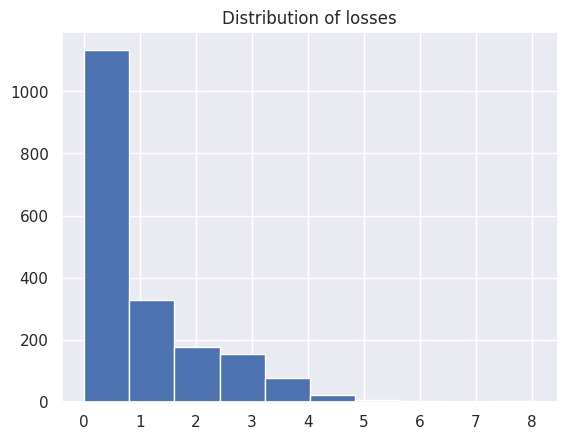

In [39]:
plt.title('Distribution of losses')
plt.hist(np.array(all_losses))
plt.show()

In [40]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)
all_losses_train = list()

with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)
        # print(inputs.shape, targets.shape, outputs.shape)
        loss = criterion(outputs, targets.long())
        all_losses_train.append(loss)

        # for inputs, labels in train_loader:
        #     outputs = net(inputs.to(device))
        #     loss = criterion(outputs, labels.long().to(device))



In [41]:
all_losses_train = [_.cpu() for _ in all_losses_train]

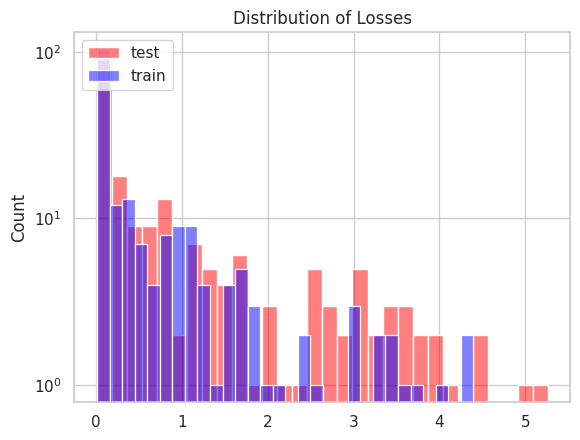

In [42]:
# plt.title('Distribution of losses')
# plt.hist(np.array(all_losses), bins=20, color='red', label='test', log=True)
# plt.hist(np.array(all_losses_train), bins=20, color='blue', label='train', log=True)
# plt.legend(loc='upper left')
# plt.show()

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming all_losses and all_losses_train are your data lists

# Set the style for the plot
sns.set(style="whitegrid")

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the distributions with opacity
sns.histplot(np.array(all_losses)[:200], bins=30, color='red', label='test', log=True, alpha=0.5, ax=ax)
sns.histplot(np.array(all_losses_train)[:200], bins=30, color='blue', label='train', log=True, alpha=0.5, ax=ax)

# Set the title and legend
plt.title('Distribution of Losses')
plt.legend(loc='upper left')

# Show the plot
plt.show()


In [43]:
np.mean(all_losses), np.mean(all_losses_train)

(0.97184473, 0.88211584)

In [98]:
with open('/content/x_patient.pkl', 'rb') as file:
    x_patient = pickle.load(file)

with open('/content/y_patient.pkl', 'rb') as file:
    y_patient = pickle.load(file)

In [46]:
y_patient

array([[list(['CD'])],
       [list(['NORM'])],
       [list(['NORM'])],
       [list(['CD'])],
       [list(['HYP', 'MI'])]], dtype=object)

In [47]:
x_patient.shape

(5, 5000, 12)

In [49]:
import numpy as np

num_parts = 10
segment_length = x_patient.shape[1] // num_parts

# Initialize an empty list to store the segmented data
segmented_data = []

# Split each ECG signal into segments
for ecg_signal in x_patient:
    ecg_segments = [ecg_signal[i:i+segment_length, :] for i in range(0, ecg_signal.shape[0], segment_length)]
    segmented_data.extend(ecg_segments)

# Convert the list of segments to a NumPy array
segmented_data = np.array(segmented_data)

print("Original Data Shape:", x_patient.shape)
print("Segmented Data Shape:", segmented_data.shape)


Original Data Shape: (5, 5000, 12)
Segmented Data Shape: (50, 500, 12)


In [62]:
import numpy as np

batch_size = 500
num_batches = x_patient.shape[1] // batch_size
batches = np.array_split(x_patient, num_batches, axis=1)


In [50]:
X_train = np.reshape(np.array(segmented_data), (50, 500, 12))

In [51]:
X_train.shape

(50, 500, 12)

In [52]:
y_train = np.load(y_train_file_path, allow_pickle=True)
y_train = y_train.reshape(len(y_train), 1)

temp = None
faulty_set = list()
count = 0
for items in y_train:

    if len(items[0]) == 0:
       count += 1
       temp = items
       faulty_set.append(temp)
       continue




In [103]:
y_train.shape

torch.Size([50])

In [54]:

y_train = y_train[np.where(y_train != temp)[0]]
label2num(y_train)
y_train = y_train.flatten().astype(np.int32)

In [55]:
y_patient

array([[list(['CD'])],
       [list(['NORM'])],
       [list(['NORM'])],
       [list(['CD'])],
       [list(['HYP', 'MI'])]], dtype=object)

In [56]:
label2num(y_patient)

In [57]:
y_patient_new = list()
for i in y_patient:
  print(np.tile(np.array(i), 10))
  y_patient_new.append(np.tile(np.array(i), 10))
y_patient_new = np.array(y_patient_new)

[3 3 3 3 3 3 3 3 3 3]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[3 3 3 3 3 3 3 3 3 3]
[4 4 4 4 4 4 4 4 4 4]


In [58]:
y_patient = y_patient_new.flatten().astype(np.int32)

In [59]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_patient, dtype=torch.float32)

In [104]:
X_train.shape, y_train.shape

(torch.Size([50, 1, 500, 12]), torch.Size([50]))

In [61]:
X_train = X_train.unsqueeze(1)

X_train.shape, y_train.shape

(torch.Size([50, 1, 500, 12]), torch.Size([50]))

In [62]:
batch_size = 1
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

In [63]:
X_train.shape, y_train.shape

(torch.Size([50, 1, 500, 12]), torch.Size([50]))

In [64]:
start_epoch = 0
net.train()
for epoch in range(start_epoch, 3):
    loss, train_acc = train(epoch)
    print(f'Total loss: {loss} || Acc: {train_acc}')
    start_epoch = epoch
    # scheduler.step(loss)


Epoch: 0
Total loss: tensor([60.2171], device='cuda:0') || Acc: 58.0

Epoch: 1
Total loss: tensor([60.2171], device='cuda:0') || Acc: 58.0

Epoch: 2
Total loss: tensor([60.2171], device='cuda:0') || Acc: 58.0


Patient Loss

In [65]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)
all_losses_train_patient = list()
net.eval()
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)
        # print(inputs.shape, targets.shape, outputs.shape)
        loss = criterion(outputs, targets.long())
        all_losses_train_patient.append(loss)

        # for inputs, labels in train_loader:
        #     outputs = net(inputs.to(device))
        #     loss = criterion(outputs, labels.long().to(device))



In [66]:
all_losses_train_patient = [_.cpu() for _ in all_losses_train_patient]

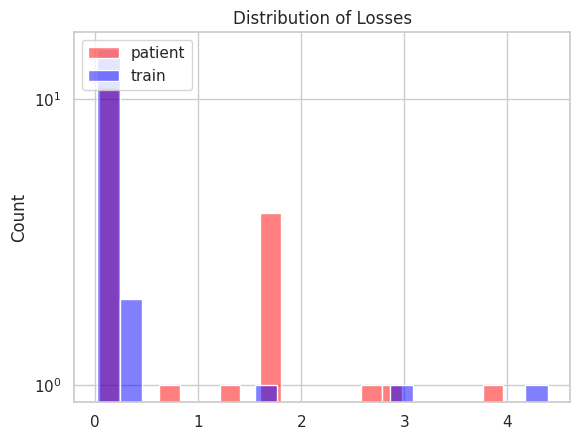

In [67]:
# PLOT
sns.set(style="whitegrid")
fig, ax = plt.subplots()
sns.histplot(np.array(all_losses_train_patient)[:20], bins=20, color='red', label='patient', log=True, alpha=0.5, ax=ax)
sns.histplot(np.array(all_losses_train)[:20], bins=20, color='blue', label='train', log=True, alpha=0.5, ax=ax)
plt.title('Distribution of Losses')
plt.legend(loc='upper left')
plt.show()

In [68]:
torch.save(net.state_dict(), 'resnet_finetuned.pth')
shutil.copy('resnet_finetuned.pth', '/content/gdrive/MyDrive/Physionet_NPY_DATA')

'/content/gdrive/MyDrive/Physionet_NPY_DATA/resnet_finetuned.pth'

In [77]:
import gc
gc.collect()

324

Unlearning Part

In [113]:
y_train = np.load(y_train_file_path, allow_pickle=True)
y_train = y_train.reshape(len(y_train), 1)

In [114]:
y_train.shape

(17302, 1)

In [115]:
X_train = np.load(X_train_file_path, allow_pickle=True)
X_test = np.load(X_test_file_path, allow_pickle=True)
y_test = np.load(y_test_file_path, allow_pickle=True)

y_test = y_test.reshape(len(y_test), 1)

X_train = X_train[:10000,:,:]
y_train = y_train[:10000]

X_train = X_train[np.where(y_train != temp)[0]]
X_test = X_test[np.where(y_test != temp)[0]]
y_test = y_test[np.where(y_test != temp)[0]]

In [116]:

to_pop = list()
sample_size = 5
count = 0
samples = 0
for i in y_train:
    if i[0] == ['CD'] and samples < sample_size:
        to_pop.append(count)
        X_train = np.delete(X_train, count, axis=0)
        y_train = np.delete(y_train, count, axis=0)
        samples += 1

    count += 1

label2num(y_test)

y_test = y_test.flatten().astype(np.int32)

In [117]:
temp = None
faulty_set = list()
count = 0
for items in y_train:

    if len(items[0]) == 0:
       count += 1
       temp = items
       faulty_set.append(temp)
       continue

y_train = y_train[np.where(y_train != temp)[0]]

label2num(y_train)
y_train = y_train.flatten().astype(np.int32)
y_train = torch.tensor(y_train, dtype=torch.float32)

In [118]:

X_train = X_train.reshape(X_train.shape[0], 1, 5000, 12)
X_test = X_test.reshape(X_test.shape[0], 1, 5000, 12)

In [119]:

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


In [120]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)


In [121]:
batch_size=16
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [122]:
load_model = False
net.train()
if load_model:
    checkpoint = torch.load('./checkpoint/res18.ckpt')
    net.load_state_dict(checkpoint['net'])
    start_epoch = checkpoint['epoch']
else:
    start_epoch = 0
print('start_epoch: %s' % start_epoch)

start_epoch: 0


In [139]:
net = ResNet34().to(device)
# chk = torch.load('resnet.pth')
# model.load_state_dict(chk['model_state_dict'])
state_dict = torch.load('/content/gdrive/MyDrive/Physionet_NPY_DATA/resnet_finetuned.pth')

# Apply the weights
net.load_state_dict(state_dict)

<All keys matched successfully>

In [140]:
train_metrics_unlearned = {
    'epoch': list(),
    'loss': list(),
    'accuracy': list()
}
test_metrics_patients = {
    'epoch': list(),
    'loss': list(),
    'accuracy': list()
}
train_loss_list = list()
accuracy_list = list()
total_epochs = 1
start_epoch = 0
for epoch in range(start_epoch, total_epochs):
    loss, accuracy = train(epoch)
    train_metrics_unlearned['epoch'].append(epoch)
    train_metrics_unlearned['loss'].append(loss)
    train_metrics_unlearned['accuracy'].append(accuracy)
    print('Total loss: %.6f' % loss)
    start_epoch = epoch
    scheduler.step(loss)

    # Validation loop
    net.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = net(inputs.to(device))
            loss = criterion(outputs, labels.long().to(device))
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
    test_metrics_patients['loss'].append(loss)
    test_metrics_patients['accuracy'].append(100.*correct/total)
    test_metrics_patients['epoch'].append(epoch)
    print(f'Epoch {epoch + 1}/{total_epochs}, Loss: {loss.item():.4f}, Validation Accuracy: {100 * correct / total:.2f}%')


Epoch: 0
Total loss: 60.217106
Epoch 1/1, Loss: 0.9323, Validation Accuracy: 60.65%


In [142]:
torch.save(net.state_dict(), 'resnet_unlearned.pth')
shutil.copy('resnet_unlearned.pth', '/content/gdrive/MyDrive/Physionet_NPY_DATA')

'/content/gdrive/MyDrive/Physionet_NPY_DATA/resnet_unlearned.pth'

In [143]:
# load patient pretrained resnet
net = ResNet34().to(device)
# chk = torch.load('resnet.pth')
# model.load_state_dict(chk['model_state_dict'])
state_dict = torch.load('/content/gdrive/MyDrive/Physionet_NPY_DATA/resnet_unlearned.pth')

# Apply the weights
net.load_state_dict(state_dict)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
all_losses_test_unlearned = list()
net.eval()
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, targets.long())
        all_losses_test_unlearned.append(loss)

In [145]:
all_losses_test_unlearned = [_.cpu() for _ in all_losses_test_unlearned]

In [124]:
# load patient pretrained resnet
net = ResNet34().to(device)
# chk = torch.load('resnet.pth')
# model.load_state_dict(chk['model_state_dict'])
state_dict = torch.load('/content/gdrive/MyDrive/Physionet_NPY_DATA/resnet.pth')

# Apply the weights
net.load_state_dict(state_dict)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
all_losses_test = list()
net.eval()
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, targets.long())
        all_losses_test.append(loss)

In [125]:
all_losses_test = [_.cpu() for _ in all_losses_test]

In [128]:
import numpy as np

with open('/content/x_patient.pkl', 'rb') as file:
    x_patient = pickle.load(file)

with open('/content/y_patient.pkl', 'rb') as file:
    y_patient = pickle.load(file)

num_parts = 10
segment_length = x_patient.shape[1] // num_parts

# Initialize an empty list to store the segmented data
segmented_data = []

# Split each ECG signal into segments
for ecg_signal in x_patient:
    ecg_segments = [ecg_signal[i:i+segment_length, :] for i in range(0, ecg_signal.shape[0], segment_length)]
    segmented_data.extend(ecg_segments)

# Convert the list of segments to a NumPy array
segmented_data = np.array(segmented_data)

print("Original Data Shape:", x_patient.shape)
print("Segmented Data Shape:", segmented_data.shape)


X_train = np.reshape(np.array(segmented_data), (50, 500, 12))

y_train = np.load(y_train_file_path, allow_pickle=True)
y_train = y_train.reshape(len(y_train), 1)

temp = None
faulty_set = list()
count = 0
for items in y_train:

    if len(items[0]) == 0:
       count += 1
       temp = items
       faulty_set.append(temp)
       continue



y_train = y_train[np.where(y_train != temp)[0]]
label2num(y_train)
y_train = y_train.flatten().astype(np.int32)

label2num(y_patient)

y_patient_new = list()
for i in y_patient:
  print(np.tile(np.array(i), 10))
  y_patient_new.append(np.tile(np.array(i), 10))
y_patient_new = np.array(y_patient_new)

y_patient = y_patient_new.flatten().astype(np.int32)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_patient, dtype=torch.float32)

X_train = X_train.unsqueeze(1)

X_train.shape, y_train.shape

batch_size = 1
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
start_epoch = 0
net.train()
for epoch in range(start_epoch, 3):
    loss, train_acc = train(epoch)
    print(f'Total loss: {loss} || Acc: {train_acc}')
    start_epoch = epoch
    # scheduler.step(loss)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)
all_losses_patient_fine_tuned = list()
net.eval()
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)
        # print(inputs.shape, targets.shape, outputs.shape)
        loss = criterion(outputs, targets.long())
        all_losses_patient_fine_tuned.append(loss)


Original Data Shape: (5, 5000, 12)
Segmented Data Shape: (50, 500, 12)
[3 3 3 3 3 3 3 3 3 3]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[3 3 3 3 3 3 3 3 3 3]
[4 4 4 4 4 4 4 4 4 4]

Epoch: 0
Total loss: tensor([60.2171], device='cuda:0') || Acc: 58.0

Epoch: 1
Total loss: tensor([60.2171], device='cuda:0') || Acc: 58.0

Epoch: 2
Total loss: tensor([60.2171], device='cuda:0') || Acc: 58.0


In [129]:
all_losses_patient_fine_tuned = [_.cpu() for _ in all_losses_patient_fine_tuned]

# Unlearned Patient

In [100]:
import numpy as np

num_parts = 10
segment_length = x_patient.shape[1] // num_parts

# Initialize an empty list to store the segmented data
segmented_data = []

# Split each ECG signal into segments
for ecg_signal in x_patient:
    ecg_segments = [ecg_signal[i:i+segment_length, :] for i in range(0, ecg_signal.shape[0], segment_length)]
    segmented_data.extend(ecg_segments)

# Convert the list of segments to a NumPy array
segmented_data = np.array(segmented_data)

print("Original Data Shape:", x_patient.shape)
print("Segmented Data Shape:", segmented_data.shape)


X_train = np.reshape(np.array(segmented_data), (50, 500, 12))

y_train = np.load(y_train_file_path, allow_pickle=True)
y_train = y_train.reshape(len(y_train), 1)

temp = None
faulty_set = list()
count = 0
for items in y_train:

    if len(items[0]) == 0:
       count += 1
       temp = items
       faulty_set.append(temp)
       continue



y_train = y_train[np.where(y_train != temp)[0]]
label2num(y_train)
y_train = y_train.flatten().astype(np.int32)

label2num(y_patient)

y_patient_new = list()
for i in y_patient:
  print(np.tile(np.array(i), 10))
  y_patient_new.append(np.tile(np.array(i), 10))
y_patient_new = np.array(y_patient_new)

y_patient = y_patient_new.flatten().astype(np.int32)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_patient, dtype=torch.float32)

X_train = X_train.unsqueeze(1)

X_train.shape, y_train.shape

batch_size = 1
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
start_epoch = 0
net.train()
for epoch in range(start_epoch, 3):
    loss, train_acc = train(epoch)
    print(f'Total loss: {loss} || Acc: {train_acc}')
    start_epoch = epoch
    # scheduler.step(loss)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)
all_losses_unlearned = list()
net.eval()
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)
        # print(inputs.shape, targets.shape, outputs.shape)
        loss = criterion(outputs, targets.long())
        all_losses_unlearned.append(loss)

        # for inputs, labels in train_loader:
        #     outputs = net(inputs.to(device))
        #     loss = criterion(outputs, labels.long().to(device))



Original Data Shape: (5, 5000, 12)
Segmented Data Shape: (50, 500, 12)
[3 3 3 3 3 3 3 3 3 3]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[3 3 3 3 3 3 3 3 3 3]
[4 4 4 4 4 4 4 4 4 4]

Epoch: 0
Total loss: tensor([60.2171], device='cuda:0') || Acc: 58.0

Epoch: 1
Total loss: tensor([60.2171], device='cuda:0') || Acc: 58.0

Epoch: 2
Total loss: tensor([60.2171], device='cuda:0') || Acc: 58.0


In [101]:
all_losses_unlearned = [_.cpu() for _ in all_losses_unlearned]

In [105]:
batch_size = 1
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

In [108]:
# load patient pretrained resnet
net = ResNet34().to(device)
# chk = torch.load('resnet.pth')
# model.load_state_dict(chk['model_state_dict'])
state_dict = torch.load('/content/gdrive/MyDrive/Physionet_NPY_DATA/resnet.pth')

# Apply the weights
net.load_state_dict(state_dict)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)
all_losses_train_patient_pretrained = list()
net.eval()
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, targets.long())
        all_losses_train_patient_pretrained.append(loss)

In [110]:
all_losses_train_patient_pretrained = [_.cpu() for _ in all_losses_train_patient_pretrained]

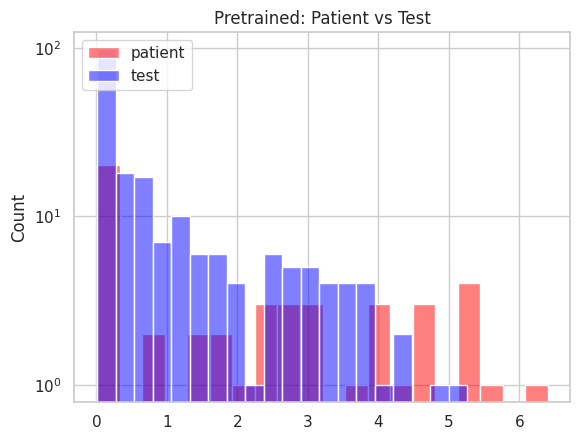

In [156]:
# PLOT
sns.set(style="whitegrid")
fig, ax = plt.subplots()
sns.histplot(np.array(all_losses_train_patient_pretrained), bins=20, color='red', label='patient', log=True, alpha=0.5, ax=ax)
sns.histplot(np.array(all_losses)[:200], bins=20, color='blue', label='test', log=True, alpha=0.5, ax=ax)

plt.title('Pretrained: Patient vs Test')
plt.legend(loc='upper left')
plt.show()

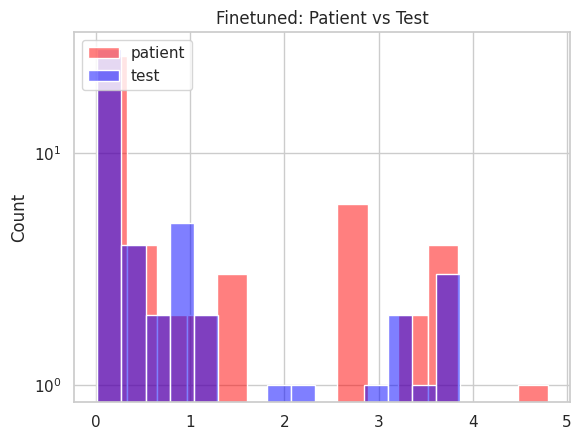

In [149]:
  # PLOT
sns.set(style="whitegrid")
fig, ax = plt.subplots()
sns.histplot(np.array(all_losses_patient_fine_tuned), bins=15, color='red', label='patient', log=True, alpha=0.5, ax=ax)
sns.histplot(np.array(all_losses_test)[:len(all_losses_patient_fine_tuned)], bins=15, color='blue', label='test', log=True, alpha=0.5, ax=ax)
plt.title('Finetuned: Patient vs Test')
plt.legend(loc='upper left')
plt.show()

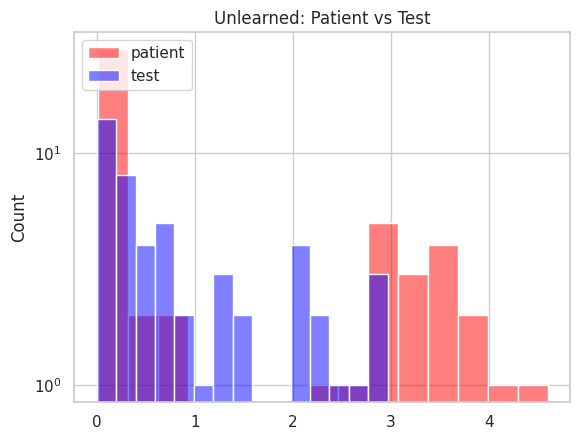

In [148]:
# PLOT
sns.set(style="whitegrid")
fig, ax = plt.subplots()
sns.histplot(np.array(all_losses_unlearned), bins=15, color='red', label='patient', log=True, alpha=0.5, ax=ax)
sns.histplot(np.array(all_losses_test_unlearned)[:len(all_losses_unlearned)], bins=15, color='blue', label='test', log=True, alpha=0.5, ax=ax)
plt.title('Unlearned: Patient vs Test')
plt.legend(loc='upper left')
plt.show()

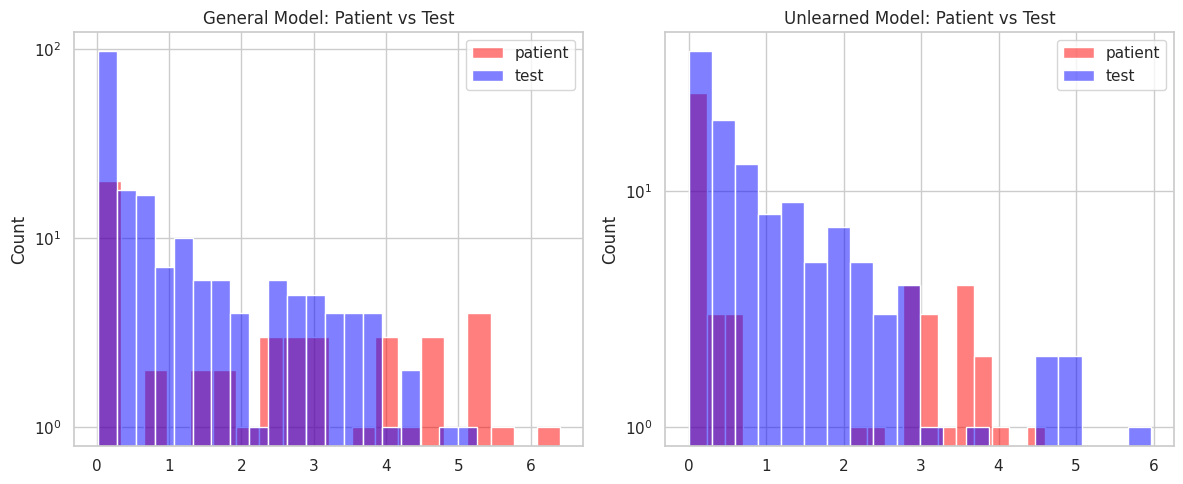

In [170]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming you have all_losses_train_patient_pretrained, all_losses, all_losses_unlearned, and all_losses_test_unlearned defined

# PLOT 1
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for Pretrained
sns.histplot(np.array(all_losses_train_patient_pretrained), bins=20, color='red', label='patient', log=True, alpha=0.5, ax=axes[0])
sns.histplot(np.array(all_losses)[:200], bins=20, color='blue', label='test', log=True, alpha=0.5, ax=axes[0])
axes[0].set_title('General Model: Patient vs Test')
axes[0].legend(loc='upper right')

# PLOT 2
# Plot for Unlearned
sns.histplot(np.array(all_losses_unlearned), bins=20, color='red', label='patient', log=True, alpha=0.5, ax=axes[1])
sns.histplot(np.array(all_losses_test_unlearned)[:120], bins=20, color='blue', label='test', log=True, alpha=0.5, ax=axes[1])
axes[1].set_title('Unlearned Model: Patient vs Test')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()


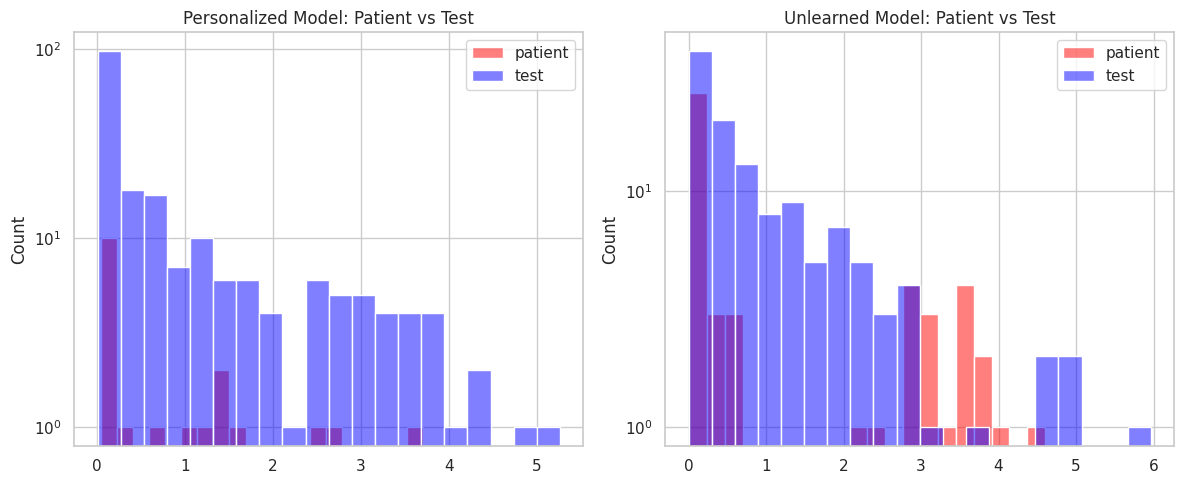

In [172]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming you have all_losses_train_patient_pretrained, all_losses, all_losses_unlearned, and all_losses_test_unlearned defined

# PLOT 1
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for Pretrained
sns.histplot(np.array(all_losses_patient_fine_tuned)[:20], bins=20, color='red', label='patient', log=True, alpha=0.5, ax=axes[0])
sns.histplot(np.array(all_losses_test)[:200], bins=20, color='blue', label='test', log=True, alpha=0.5, ax=axes[0])
axes[0].set_title('Personalized Model: Patient vs Test')
axes[0].legend(loc='upper right')

# PLOT 2
# Plot for Unlearned
sns.histplot(np.array(all_losses_unlearned), bins=20, color='red', label='patient', log=True, alpha=0.5, ax=axes[1])
sns.histplot(np.array(all_losses_test_unlearned)[:120], bins=20, color='blue', label='test', log=True, alpha=0.5, ax=axes[1])
axes[1].set_title('Unlearned Model: Patient vs Test')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()


In [151]:
import re

log_string = """
Epoch: 0
[1,   100] loss: 209.221909 |  Acc: 43.688% (699/1600)
[1,   200] loss: 346.057556 |  Acc: 46.156% (1477/3200)
[1,   300] loss: 481.460724 |  Acc: 47.000% (2256/4800)
[1,   400] loss: 611.672974 |  Acc: 48.453% (3101/6400)
[1,   500] loss: 745.223083 |  Acc: 49.125% (3930/8000)
[1,   600] loss: 874.585083 |  Acc: 49.719% (4773/9600)
Total loss: 893.174988
Epoch 1/5, Loss: 1.9355, Validation Accuracy: 44.45%

Epoch: 1
[2,   100] loss: 124.082832 |  Acc: 55.812% (893/1600)
[2,   200] loss: 247.142136 |  Acc: 55.875% (1788/3200)
[2,   300] loss: 366.627838 |  Acc: 56.708% (2722/4800)
[2,   400] loss: 487.728302 |  Acc: 56.438% (3612/6400)
[2,   500] loss: 608.107910 |  Acc: 56.375% (4510/8000)
[2,   600] loss: 724.360474 |  Acc: 56.698% (5443/9600)
Total loss: 743.189331
Epoch 2/5, Loss: 1.1979, Validation Accuracy: 54.39%
"""

# Regular expressions to extract values
epoch_pattern = re.compile(r"Epoch: (\d+)")
loss_pattern = re.compile(r"Loss: (\d+\.\d+)")
accuracy_pattern = re.compile(r"Acc: (\d+\.\d+)%")
validation_accuracy_pattern = re.compile(r"Validation Accuracy: (\d+\.\d+)%")

# Initialize lists to store parsed values
epochs = []
loss_values = []
accuracy_values = []
validation_accuracy_values = []

# Split log into lines
log_lines = log_string.split('\n')

for line in log_lines:
    epoch_match = epoch_pattern.search(line)
    if epoch_match:
        epochs.append(int(epoch_match.group(1)))

    loss_match = loss_pattern.search(line)
    if loss_match:
        loss_values.append(float(loss_match.group(1)))

    accuracy_match = accuracy_pattern.search(line)
    if accuracy_match:
        accuracy_values.append(float(accuracy_match.group(1)))

    validation_accuracy_match = validation_accuracy_pattern.search(line)
    if validation_accuracy_match:
        validation_accuracy_values.append(float(validation_accuracy_match.group(1)))

# Print the parsed values
print("Epochs:", epochs)
print("Loss values:", loss_values)
print("Accuracy values:", accuracy_values)
print("Validation Accuracy values:", validation_accuracy_values)


Epochs: [0, 1]
Loss values: [1.9355, 1.1979]
Accuracy values: [43.688, 46.156, 47.0, 48.453, 49.125, 49.719, 55.812, 55.875, 56.708, 56.438, 56.375, 56.698]
Validation Accuracy values: [44.45, 54.39]


In [167]:
losses = [893.174988, 743.189331, 667.898804, 573.709473, 550.925415]

acc = [49.719, 56.698, 60.188, 66.198, 67.750]

validation = [44.45, 54.39, 60.44, 63.81, 65.07]

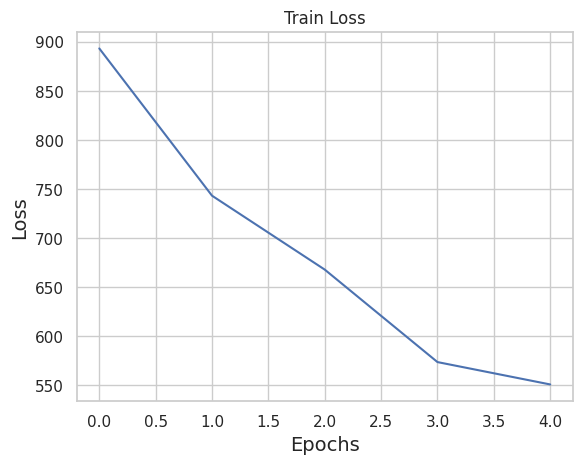

In [168]:
plt.title("Train Loss")
plt.plot(losses)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.show()

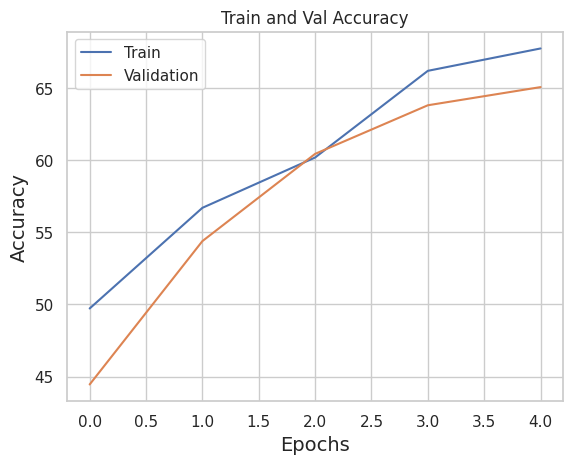

In [176]:
plt.title("Train and Val Accuracy")
plt.plot(acc, label='Train')
plt.plot(validation, label='Validation')
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend(loc='upper left')
plt.show()